In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae
#from utils.metrics import log_rank, cox_estimation

import os
import json

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Simulate the initial data

In [2]:
n_samples = 600
n_features_bytype = 4
n_active_features = 3 
treatment_effect = 0.
surv_type = "surv_weibull"

control, treated, types = simulation(treatment_effect, n_samples, independent = False, surv_type = 'surv_piecewise', 
                                     feature_types_list = ["pos", "real", "cat"], n_features_bytype = 4, 
                                     n_active_features = 3 , p_treated = 0.5, shape_T = 2, shape_C = 2, scale_C = 6., 
                                     scale_C_indep = 2.5, data_types_create = True, seed=0)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
1,0.620116,0.987304,0.494666,0.166897,-1.119509,-0.210453,-0.368761,-1.145711,1.0,0.0,0.0,0.0,0.224481,1
4,0.874445,0.820363,1.377438,0.452029,0.226290,0.216713,1.131835,1.369845,1.0,1.0,1.0,1.0,6.348754,0
11,0.386280,0.632000,1.038750,0.349346,-0.678958,0.541789,-0.116268,0.152934,1.0,1.0,0.0,1.0,1.464392,1
12,1.453227,0.145134,0.593687,1.056960,-2.069638,-2.300999,-0.460192,-1.642681,0.0,0.0,0.0,0.0,0.493137,0
14,0.461897,1.139139,0.494944,0.213642,-0.509902,-1.174044,-0.240497,-0.080935,0.0,0.0,0.0,0.0,0.655399,1


In [4]:
print("Percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

Percent of uncensored data in control set 0.860 and in treated set 0.860


## Save data

In [5]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [6]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [8]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

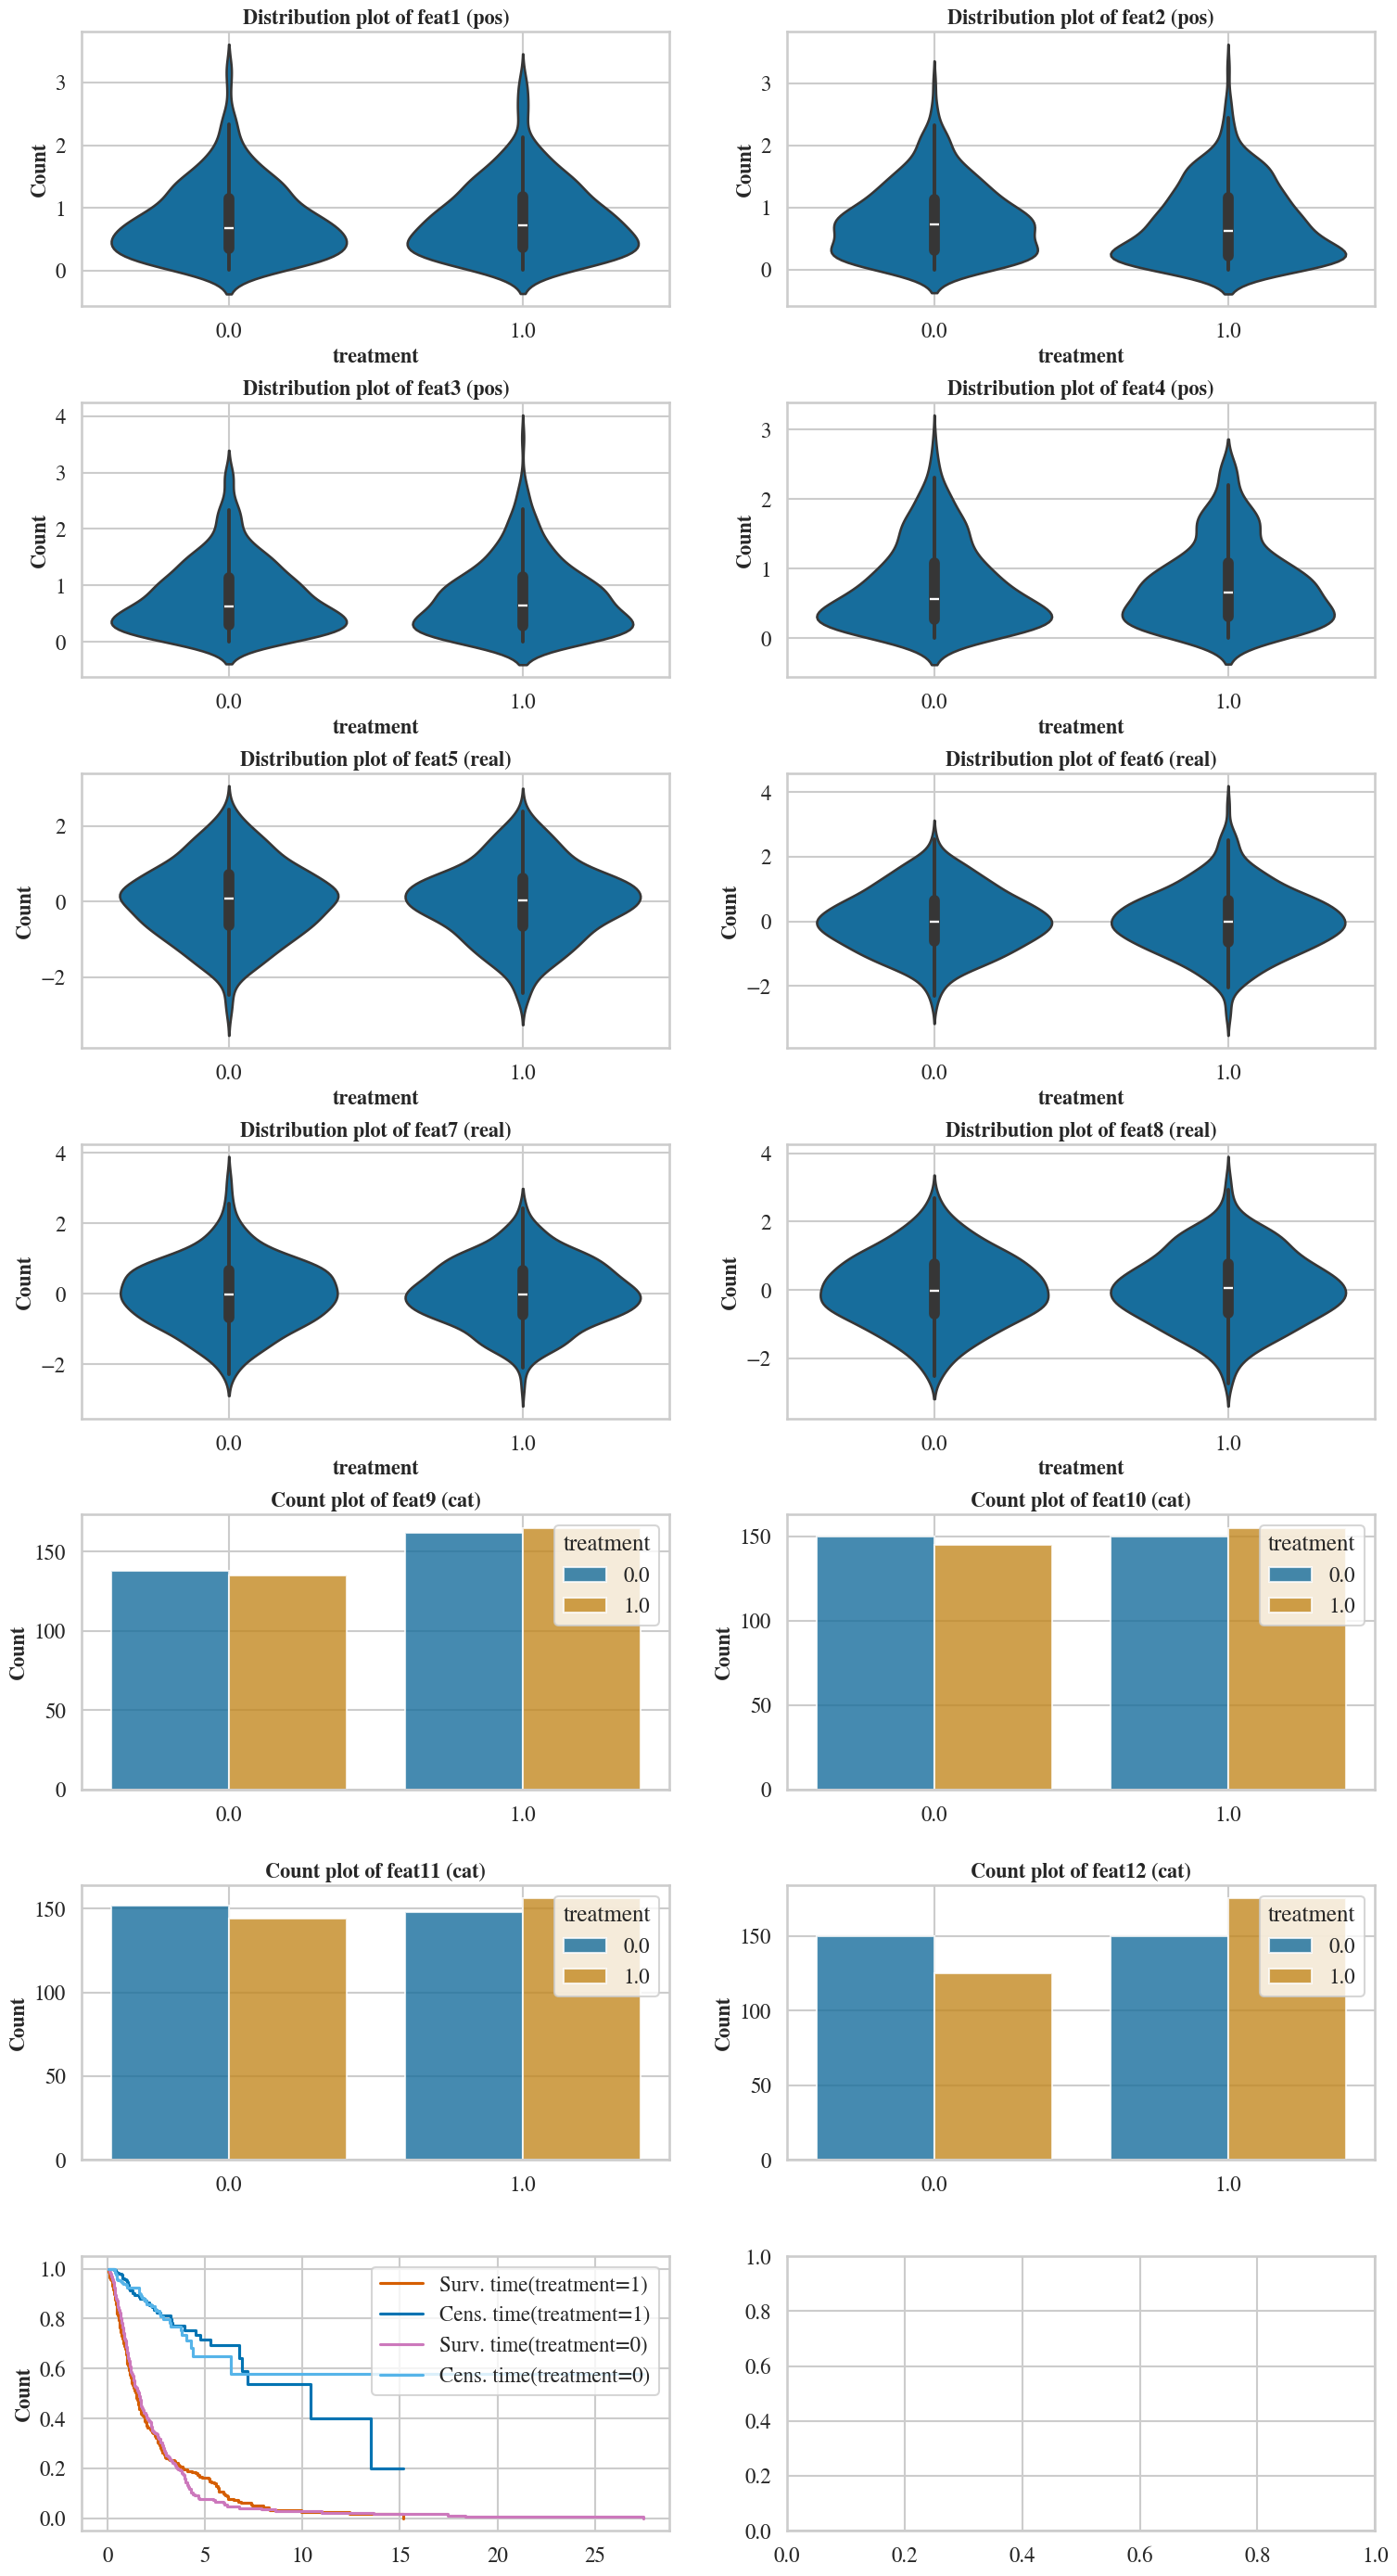

In [9]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

## Hyperparameters optimization

In [10]:
# Parameters of the optuna study
name_config = "simu_N{}_nfeat{}_t{}_{}".format(n_samples, n_features_bytype, treatment_effect, surv_type)
n_trials = 5 # number of trials for each generator
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric 

# The optuna studies and the best hyperparameters sets are saved in the folder 'optuna_results/' in the files : 
# - 'optuna_study_{name_config}_{generator_name}.db' 
# - 'best_params_{name_config}_{generator_name}.json'

In [11]:
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                   "HI-VAE_piecewise" : surv_hivae,
                   "Surv-GAN" : surv_gan,
                   "Surv-VAE" : surv_vae}

best_params_dict, study_dict = {}, {}
for generator_name in generators_sel:
    db_file = "optuna_results/optuna_study_{}_{}.db".format(name_config, generator_name)
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
    else: 
        print("Creating new optuna study for {}...".format(generator_name))
        if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
            feat_types_dict_ext = feat_types_dict.copy()
            for i in range(len(feat_types_dict)):
                if feat_types_dict_ext[i]['name'] == "survcens":
                    if generator_name in["HI-VAE_weibull"]:
                        feat_types_dict_ext[i]["type"] = 'surv_weibull'
                    else:
                        feat_types_dict_ext[i]["type"] = 'surv_piecewise'
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search(data_init_control_encoded, 
                                                                                              data_init_control,
                                                                                              miss_mask_control, 
                                                                                              true_miss_mask_control,
                                                                                              feat_types_dict_ext, 
                                                                                              n_generated_dataset, 
                                                                                              n_splits=n_splits,
                                                                                              n_trials=n_trials, 
                                                                                              columns=fnames,
                                                                                              epochs=1000,
                                                                                              study_name="optuna_results/optuna_study_{}_{}".format(name_config, generator_name))
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "w") as f:
                json.dump(best_params, f)
        else: 
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search(data_init_control, 
                                                                                            columns=fnames, 
                                                                                            target_column="censor", 
                                                                                            time_to_event_column="time", 
                                                                                            n_generated_dataset=n_generated_dataset, 
                                                                                            n_splits=n_splits,
                                                                                            n_trials=n_trials, 
                                                                                            study_name="optuna_results/optuna_study_{}_{}".format(name_config, generator_name))
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "w") as f:
                json.dump(best_params, f)

This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.


## Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

### Run with defaut_params

In [12]:
# the datasets used for training is data_init_control
n_generated_dataset = 50
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control_encoded, data_init_control, fnames, miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0664, ELBO_train: -14.18623304, KL_z: 2.08413291, KL_s: 0.10068774, reconstruction loss: -12.00141239
Epoch: [100]  time: 1.5769, ELBO_train: -10.64812994, KL_z: 0.86596605, KL_s: 0.04175127, reconstruction loss: -9.74041262
Epoch: [200]  time: 2.9664, ELBO_train: -10.50365591, KL_z: 1.22884429, KL_s: 0.03204012, reconstruction loss: -9.24277151
Epoch: [300]  time: 4.6471, ELBO_train: -10.99151278, KL_z: 1.40856117, KL_s: 0.03271711, reconstruction loss: -9.55023450
Epoch: [400]  time: 6.2350, ELBO_train: -10.31103134, KL_z: 1.55592954, KL_s: 0.03294730, reconstruction loss: -8.72215450
Epoch: [500]  time: 7.8361, ELBO_train: -9.85636997, KL_z: 1.61885577, KL_s: 0.03507078, reconstruction loss: -8.20244342
Epoch: [600]  time: 9.4506, ELBO_train: -10.16138220, KL_z: 1.71456409, KL_s: 0.04061055, reconstruction loss: -8.40620756
Epoch: [700]  time: 10.9820, ELBO_train: -10.37230110, KL_z: 1.84951204, KL_s: 0.03982687, reconstruction lo

### Run models with best hyperparameters

In [13]:
best_params_dict = {}
for generator_name in generators_sel:
    with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "r") as f:
        best_params_dict[generator_name] = json.load(f)

In [14]:
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params[generator_name] = generators_dict[generator_name].run(data_init_control_encoded, 
                                                                                                data_init_control, 
                                                                                                fnames, miss_mask_control, 
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params)
    else:
        data_gen_control_dict_best_params[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0189, ELBO_train: -14.26759052, KL_z: 2.07248545, KL_s: 0.10146141, reconstruction loss: -12.09364367
Epoch: [100]  time: 1.6296, ELBO_train: -12.12913370, KL_z: 1.16064817, KL_s: 0.06692779, reconstruction loss: -10.90155774
Epoch: [200]  time: 3.1162, ELBO_train: -11.25151348, KL_z: 0.91900665, KL_s: 0.06187499, reconstruction loss: -10.27063185
Epoch: [300]  time: 4.7394, ELBO_train: -11.33736181, KL_z: 1.00113568, KL_s: 0.05827451, reconstruction loss: -10.27795163
Epoch: [400]  time: 6.4119, ELBO_train: -10.84663677, KL_z: 1.04761040, KL_s: 0.05463338, reconstruction loss: -9.74439299
Epoch: [500]  time: 7.9029, ELBO_train: -10.86801338, KL_z: 1.14330620, KL_s: 0.05455399, reconstruction loss: -9.67015320
Epoch: [600]  time: 9.5203, ELBO_train: -10.60398149, KL_z: 1.19596589, KL_s: 0.05418921, reconstruction loss: -9.35382640
Epoch: [700]  time: 11.0697, ELBO_train: -10.80810690, KL_z: 1.23644817, KL_s: 0.05433905, reconstructio

### Compare the results between best params with default params

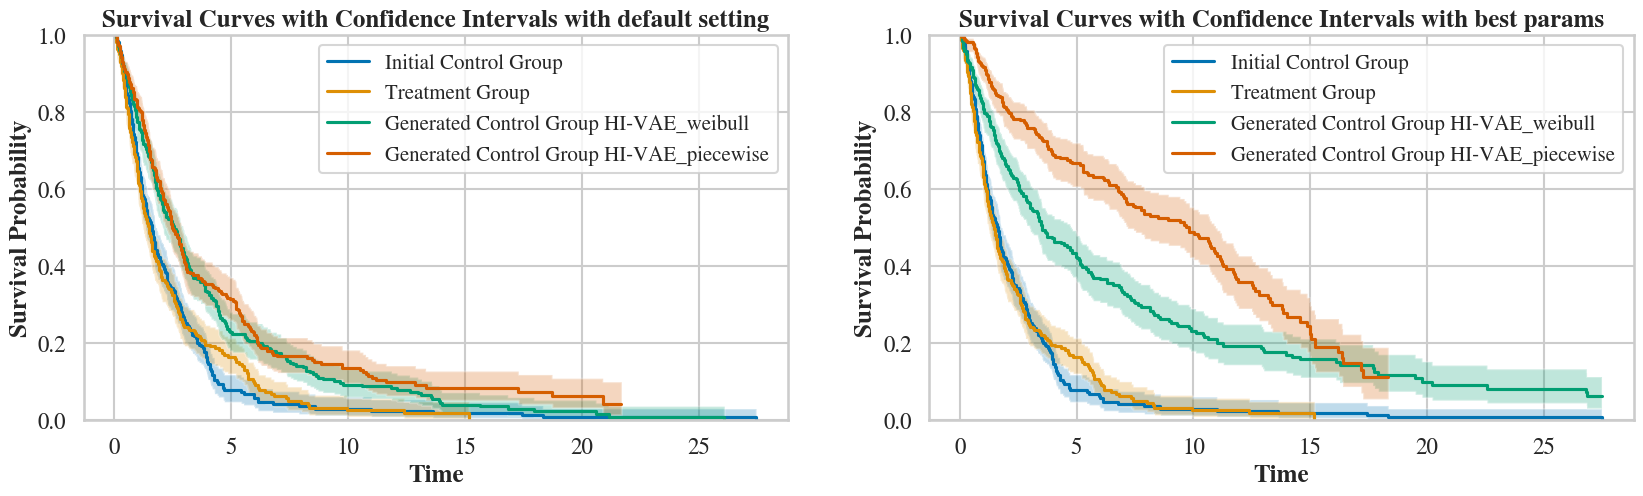

In [15]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[0])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[0])
p_value_default_str = "-Log rank pvalues: \n Initial {:.2f}"
p_value_default_value = [compute_logrank_test(control, treated)]

sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[0])
    p_value_default_str += "\n " + generator_name + " {:.2f}"
    p_value_default_value.append(compute_logrank_test(df_syn_sel, treated))

axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=15)
axs[0].set_xlabel("Time", fontweight="semibold")
axs[0].set_ylabel("Survival Probability", fontweight="semibold")
axs[0].set_title("Survival Curves with Confidence Intervals with default setting", fontweight="bold")

kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[1])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[1])
p_value_best_str = "-Log rank pvalues: \n Initial {:.2f}"
p_value_best_value = [compute_logrank_test(control, treated)]

sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[1])
    p_value_best_str += "\n " + generator_name + " {:.2f}"
    p_value_best_value.append(compute_logrank_test(df_syn_sel, treated))

axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=15)
axs[1].set_xlabel("Time", fontweight="semibold")
axs[1].set_ylabel("Survival Probability", fontweight="semibold")
axs[1].set_title("Survival Curves with Confidence Intervals with best params", fontweight="bold")
plt.show()

In [16]:
print("DEFAULT")
print(p_value_default_str.format(*p_value_default_value))
print("BEST")
print(p_value_best_str.format(*p_value_best_value))

DEFAULT
-Log rank pvalues: 
 Initial 0.11
 HI-VAE_weibull 14.58
 HI-VAE_piecewise 19.44
BEST
-Log rank pvalues: 
 Initial 0.11
 HI-VAE_weibull 41.41
 HI-VAE_piecewise 111.95


## Monte-Carlo experiments

In [49]:
from utils.metrics import fit_cox_model, general_metrics

dataset_name = "Simulations"
treat_effects = np.arange(0., 1.1, 0.8)
n_generated_dataset = 50
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise"]
synthcity_metrics_sel = ['J-S distance', 'KS test', 'Survival curves distance', 'Detection XGB', 'NNDR', 'K-map score']
n_MC_exp = 3

simu_num = []
H0_coef = []
log_p_value_init = []
log_p_value_gen_dict = {}
est_cox_coef_init = []
est_cox_coef_se_init = []
est_cox_coef_gen_dict = {}
est_cox_coef_se_gen_dict = {}
synthcity_metrics_res_dict = {}
for generator_name in generators_sel:
    log_p_value_gen_dict[generator_name] = []
    est_cox_coef_gen_dict[generator_name] = []
    est_cox_coef_se_gen_dict[generator_name] = []
    synthcity_metrics_res_dict[generator_name] = pd.DataFrame()

seed = 0
for t in treat_effects:
    treatment_effect = t
    print("Treatment_effect", treatment_effect)
    for m in np.arange(n_MC_exp):
        if m % 10 == 0:
            print("Monte-Carlo experiment", m)
        # To make sure the difference between simulated dataset, increase seed value each time
        seed += 1
        control, treated, types = simulation(treatment_effect, n_samples, independent = False, surv_type = 'surv_piecewise', 
                                             feature_types_list = ["pos", "real", "cat"], n_features_bytype = 4, 
                                             n_active_features = 3 , p_treated = 0.5, shape_T = 2, shape_C = 2, 
                                             scale_C = 6., scale_C_indep = 2.5, data_types_create = True, seed=seed)


        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control = "./dataset/" + dataset_name + "/data_control.csv"
        data_file_treated = "./dataset/" + dataset_name + "/data_treated.csv"
        feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
        feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"
       
        control.to_csv(data_file_control, index=False , header=False)
        treated.to_csv(data_file_treated, index=False , header=False)
        types.to_csv(feat_types_file_control)
        types.to_csv(feat_types_file_treated)


        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                             feat_types_file_control, 
                                                                                                                             miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

        # Format data in dataframe
        fnames = types['name'][:-1].tolist()
        fnames.append("time")#.append("censor")
        fnames.append("censor")

        # Format data in dataframe
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

        # Update dataframe
        df_init_treated["treatment"] = 1
        df_init_control["treatment"] = 0

        df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)
        columns = ['time', 'censor', 'treatment']
        coef_init, _, _, se_init = fit_cox_model(df_init, columns)

        est_cox_coef_init += [coef_init[0]] * n_generated_dataset
        est_cox_coef_se_init += [se_init[0]] * n_generated_dataset
        
        p_value_init = compute_logrank_test(df_init_control, df_init_treated)
        log_p_value_init += [p_value_init] * n_generated_dataset
        H0_coef += [treatment_effect] * n_generated_dataset
        simu_num += [m] * n_generated_dataset

        for generator_name in generators_sel:
            best_params = best_params_dict[generator_name]
            if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
                feat_types_dict_ext = feat_types_dict.copy()
                for i in range(len(feat_types_dict)):
                    if feat_types_dict_ext[i]['name'] == "survcens":
                        if generator_name in["HI-VAE_weibull"]:
                            feat_types_dict_ext[i]["type"] = 'surv_weibull'
                        else:
                            feat_types_dict_ext[i]["type"] = 'surv_piecewise'
                data_gen_control = generators_dict[generator_name].run(data_init_control_encoded, data_init_control, 
                                                                       fnames, miss_mask_control, true_miss_mask_control, 
                                                                       feat_types_dict_ext, n_generated_dataset, 
                                                                       params=best_params)
            else:
                data_gen_control = generators_dict[generator_name].run(data_init_control, columns=fnames, 
                                                                       target_column="censor", time_to_event_column="time", 
                                                                       n_generated_dataset=n_generated_dataset, params=best_params)

            log_p_value_gen_list = []
            est_cox_coef_gen = []
            est_cox_coef_se_gen = []
            list_df_gen_control = []

            for i in range(n_generated_dataset):
                df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
                df_gen_control["treatment"] = 0
                list_df_gen_control.append(df_gen_control)
                log_p_value_gen_list.append(compute_logrank_test(df_gen_control, treated))
                df_gen = pd.concat([df_gen_control, df_init_treated], ignore_index=True)
                columns = ['time', 'censor', 'treatment']
                coef_gen, _, _, se_gen = fit_cox_model(df_gen, columns)
                est_cox_coef_gen.append(coef_gen[0])
                est_cox_coef_se_gen.append(se_gen[0])

            synthcity_metrics_res = general_metrics(df_init_control, list_df_gen_control, generator_name)[synthcity_metrics_sel]

            log_p_value_gen_dict[generator_name] += log_p_value_gen_list
            est_cox_coef_gen_dict[generator_name] += est_cox_coef_gen
            est_cox_coef_se_gen_dict[generator_name] += est_cox_coef_se_gen
            synthcity_metrics_res_dict[generator_name] = pd.concat([synthcity_metrics_res_dict[generator_name], 
                                                                    synthcity_metrics_res])

Treatment_effect 0.0
Monte-Carlo experiment 0
Epoch: [ 0]  time: 0.0798, ELBO_train: -14.77322483, KL_z: 2.10849428, KL_s: 0.10695803, reconstruction loss: -12.55777252
Epoch: [100]  time: 1.6545, ELBO_train: -12.61178160, KL_z: 1.11285102, KL_s: 0.06997252, reconstruction loss: -11.42895806
Epoch: [200]  time: 3.1997, ELBO_train: -11.96750641, KL_z: 0.94637802, KL_s: 0.06376660, reconstruction loss: -10.95736179
Epoch: [300]  time: 4.7555, ELBO_train: -11.33066893, KL_z: 1.00126767, KL_s: 0.06062233, reconstruction loss: -10.26877892
Epoch: [400]  time: 6.4396, ELBO_train: -11.54362011, KL_z: 1.05661571, KL_s: 0.05965459, reconstruction loss: -10.42734981
Epoch: [500]  time: 8.1986, ELBO_train: -11.28400135, KL_z: 1.13381869, KL_s: 0.05732608, reconstruction loss: -10.09285659
Epoch: [600]  time: 9.7218, ELBO_train: -11.45656633, KL_z: 1.22379053, KL_s: 0.05747998, reconstruction loss: -10.17529583
Epoch: [700]  time: 11.2897, ELBO_train: -11.56706905, KL_z: 1.27774614, KL_s: 0.058186

In [51]:
results = pd.DataFrame({'XP_num' : simu_num, 
                        "H0_coef" : H0_coef,
                        "log_pvalue_init" : log_p_value_init, 
                        "est_cox_coef_init" : est_cox_coef_init,
                        "est_cox_coef_se_init" : est_cox_coef_se_init})

for generator_name in generators_sel:
    results["log_pvalue_" + generator_name] = log_p_value_gen_dict[generator_name]
    results["est_cox_coef_" + generator_name] = est_cox_coef_gen_dict[generator_name]
    results["est_cox_coef_se_" + generator_name] = est_cox_coef_se_gen_dict[generator_name]
    for metric in synthcity_metrics_sel:
        results[metric + "_" + generator_name] = synthcity_metrics_res_dict[generator_name][metric].values

results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

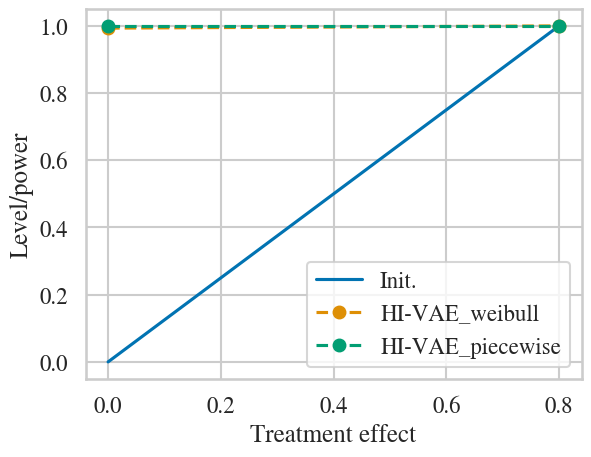

In [52]:
results_ext = results.copy(deep=True)
results_ext["reject_H0_init"] = results_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
plt.plot(treat_effects, power_init, '-', label = "Init.")

for generator_name in generators_sel:
    results_ext["reject_H0_gen_" + generator_name] = results_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    plt.plot(treat_effects, power_gen, '--', marker='o',label = generator_name)

plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.legend()
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

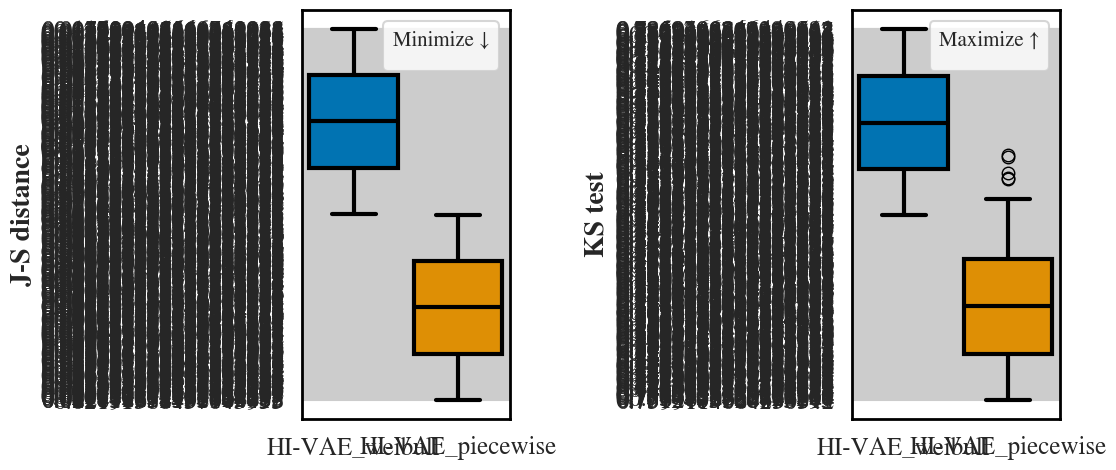

In [53]:
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

metrics=[['J-S distance', "min"], ['KS test', "max"]]
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs = plt.subplots(1, num_metrics, figsize=(3 * num_metrics * n_learners, 6))

if num_metrics == 1:
    axs = [axs]  # ensure axs is iterable

for i, ax in enumerate(axs):
    # Format axis spines
    metric_name, opt = metrics[i]
    metric_df = pd.DataFrame()
    for generator_name in generators_sel:
        metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results.shape[0], 
                                                        results[metric_name + "_" + generator_name]]).T,
                                                        columns=['generator', metric_name])])
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

    sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                linewidth = 3, saturation = 1, palette = 'colorblind', 
                width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
    ax.set_xlabel('')
    ax.set_ylabel(metric_name, fontsize=20, fontweight="semibold")
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    if opt == "max":
        ax.legend(title='Maximize \u2191', title_fontsize=15)
    else:
        ax.legend(title='Minimize \u2193', title_fontsize=15)
plt.tight_layout(pad=3)
plt.show()

In [64]:
from utils.metrics import estimate_agreement, decision_agreement, standardized_difference, ci_overlap
columns = ['time', 'censor', 'treatment']

# score_df = pd.DataFrame(columns=["Generator", "Treatment_effect", "MC_exp", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
score_df = pd.DataFrame(columns=["Generator", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
for treatment_effect in np.arange(0., 1.1, 0.8):
    results_treat = results[results.H0_coef == treatment_effect]
    cox_init = results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values
    for m in range(n_MC_exp):
        results_MC = results_treat[(results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]] == cox_init[m]).all(axis=1)]
        coef_init, se_init = results_MC[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values[0]
        ci_init = (coef_init - 1.96 * se_init, coef_init + 1.96 * se_init)

        for generator in generators_sel:
            coef_syn, se_syn = results_MC[["est_cox_coef_" + generator, "est_cox_coef_se_" + generator]].values.T
            max_len_samples = len(coef_syn)
            list_len_samples = np.arange(int(.2 * max_len_samples), max_len_samples, int(.2 * max_len_samples)).tolist()
            if max_len_samples not in list_len_samples:
                list_len_samples += [max_len_samples]
            for j in list_len_samples:
                coef_syn_, se_syn_ = np.array(coef_syn)[:j], np.array(se_syn)[:j]
                coef_syn_mean = coef_syn_.mean()
                var_syn_mean = (se_syn_**2).mean()
                # imputation_var_syn = (1 / (len(coef_syn) - 1)) * np.sum([(coef_syn_ - coef_syn_mean)**2 for coef_syn_ in coef_syn])
                # adjusted_var_syn = (imputation_var_syn / len(coef_syn)) + var_syn_mean
                adjusted_var_syn = (1/j + 1) * var_syn_mean
                ci_syn = (coef_syn_mean - 1.96 * np.sqrt(adjusted_var_syn), coef_syn_mean + 1.96 * np.sqrt(adjusted_var_syn))

                res = [estimate_agreement(ci_init, coef_syn_mean),
                    decision_agreement(coef_init, ci_init, coef_syn_mean, ci_syn),
                    standardized_difference(coef_init, coef_syn_mean, se_init),
                    ci_overlap(ci_init, ci_syn)]

                # score_df.loc[len(score_df)] = [generator, treatment_effect, m, j] + res
                score_df.loc[len(score_df)] = [generator, j] + res

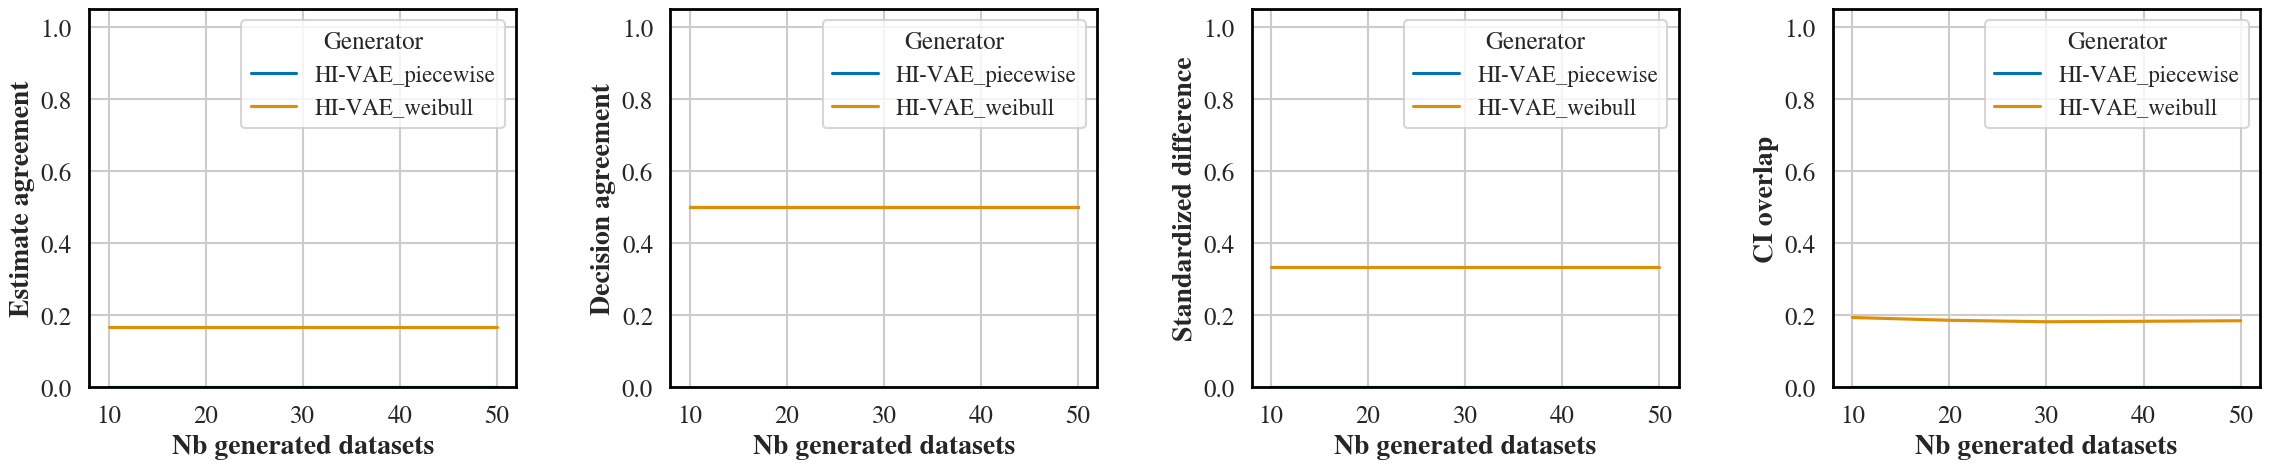

In [65]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(score_df.groupby(['Generator', 'Nb generated datasets'], as_index=False).mean())